# A notebook in R for modelling species distributions using the standard Maximum Entropy Model

In this notebook we will compute the Maximum Entropy model for predicting species distributions using presence-only data. This method has been the cannonical model in predicting species records that lack real absences. 
For achiving this we will use the R package maxnet (cite article 2017, black box), an *Open Source* version of the MaxEnt java application used in earlier studies (Philips, et.al 2006).

The MaxEnt model requires three data sources: i) environmental (covariates), ii) occurrence records (species presence) and ii) background sample (independent environmental locations).
For the purposes of this comparison we will use the same background sample as in the Presence-only models (CAR). 

## Caveats
The MaxEnt model is a pointwise model

No smapling bias , taken all data



In [5]:
library(dplyr)
library(purrr)
library(biospytial.rwrapper)

In [6]:
## Read adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]
# Convert to numeric
TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

names(TDF)[23] <- 'covid2'
DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Plantae,LUCA),
                              species=pseudo_absence_naive(Pinophyta,Plantae))
                    
                    
formula_sample=sample~Disttoroadm+Populationm #+factor(tipos)
formula_presence=species~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)

burnin = 50000
n.sample = 100000
thin = 50    

In [16]:
#install.packages('maxnet')
library(maxnet)

In [26]:
?maxnet::maxnet.formula

In [27]:
?maxnet.formula

In [31]:
names(TDF)

[1] "X"               "LUCA"            "Plantae"         "Pinophyta"      
 [5] "Abies"           "cellids"         "Disttoroadm"     "Elevationm"     
 [9] "MaxTempm"        "MeanTempm"       "MinTempm"        "Populationm"    
[13] "Precipitationm"  "SolarRadiationm" "VaporPresm"      "WindSpm"        
[17] "Longitude"       "Latitude"        "wwfmhtnum"       "wwfmhtnam"      
[21] "covid"           "name"            "covid2"          "tipos"          
[25] "geometry"

In [58]:
predictors = model.frame(formula = ~Disttoroadm+Populationm,data=DataFrame)
presences = DataFrame$species

In [77]:
me_mod = maxnet(TDF$Pinophyta, predictors, maxnet.formula(TDF$Pinophyta,predictors,classes='l'))

In [107]:
pred_vals = predict(me_mod,predictors,type='cloglog')

In [108]:

## Save to posterity
chain = cbind(TDF$cellids,pred_vals)
colnames(chain) <- c("cellids", "maxentPines")
file_ = '/outputs/presence_only_models/maxent_pines.csv'

write.csv(chain,file_)

## Here put the evaluations code

In [125]:
install.packages('sdm')

Warning message in install.packages("sdm"):
“installation of package ‘sdm’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [124]:
library('sdm')

ERROR: Error in library("sdm"): there is no package called ‘sdm’


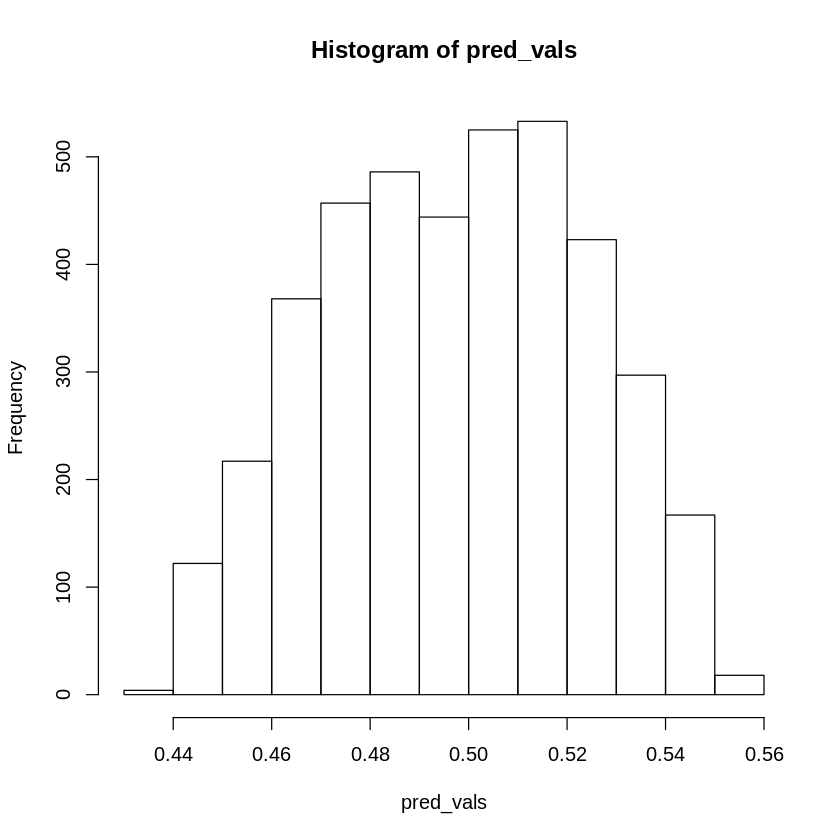

In [89]:
hist(pred_vals)

In [83]:
summary(me_mod)

               Length Class     Mode     
a0             200    -none-    numeric  
beta           400    dgCMatrix S4       
df             200    -none-    numeric  
dim              2    -none-    numeric  
lambda         200    -none-    numeric  
dev.ratio      200    -none-    numeric  
nulldev          1    -none-    numeric  
npasses          1    -none-    numeric  
jerr             1    -none-    numeric  
offset           1    -none-    logical  
classnames       2    -none-    character
call             8    -none-    call     
nobs             1    -none-    numeric  
betas            2    -none-    numeric  
alpha            1    -none-    numeric  
entropy          1    -none-    numeric  
penalty.factor   2    -none-    numeric  
featuremins      2    -none-    numeric  
featuremaxs      2    -none-    numeric  
varmin           2    -none-    numeric  
varmax           2    -none-    numeric  
samplemeans      2    -none-    list     
levels           2    -none-    li

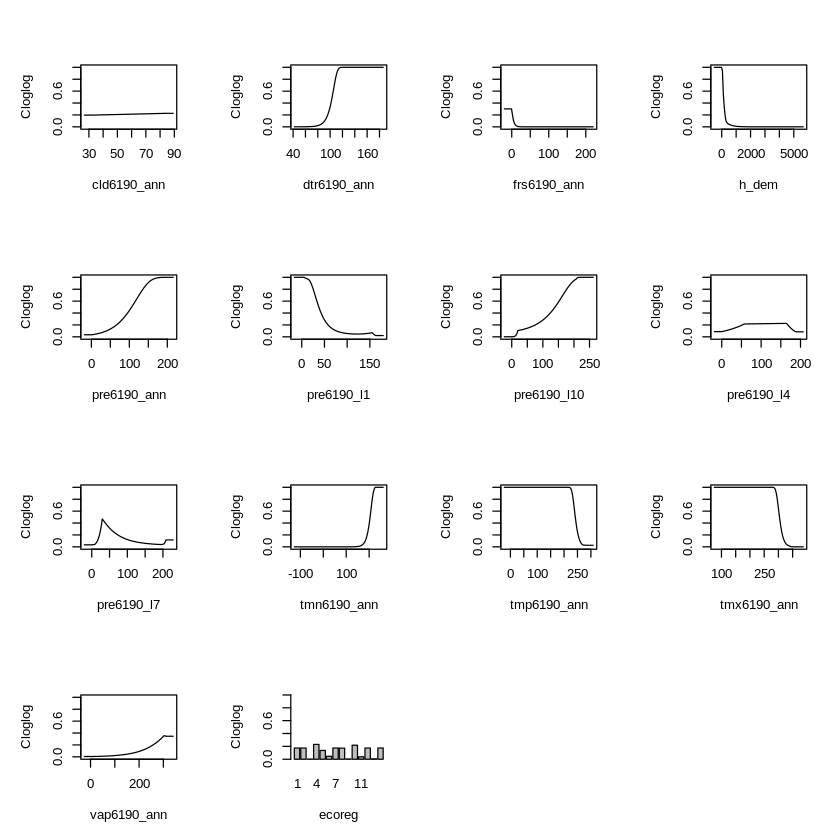

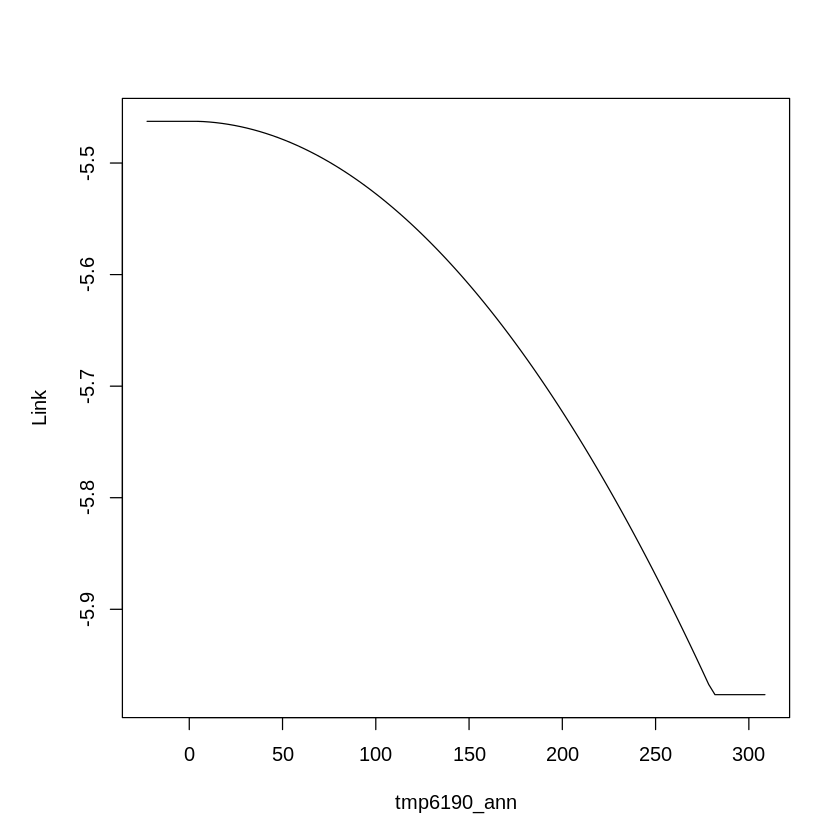

In [44]:
data(bradypus)
p <- bradypus$presence
data <- bradypus[,-1]
mod <- maxnet(p, data)
plot(mod, type="cloglog")
mod <- maxnet(p, data, maxnet.formula(p, data, classes="lq"))
plot(mod, "tmp6190_ann")

In [53]:
maxnet.formula(presences,predictors,classes="l")

~Disttoroadm + Populationm - 1
<environment: 0x7f6e1d24d840>

In [48]:
names(data)

[1] "cld6190_ann" "dtr6190_ann" "ecoreg"      "frs6190_ann" "h_dem"      
 [6] "pre6190_ann" "pre6190_l1"  "pre6190_l10" "pre6190_l4"  "pre6190_l7" 
[11] "tmn6190_ann" "tmp6190_ann" "tmx6190_ann" "vap6190_ann"

In [25]:
subset(TDF, select=-Pinophyta)

X,LUCA,Plantae,Abies,cellids,Disttoroadm,Elevationm,MaxTempm,MeanTempm,MinTempm,⋯,WindSpm,Longitude,Latitude,wwfmhtnum,wwfmhtnam,covid,name,covid2,tipos,geometry
632,0,0,0,233546,277,3029,2353,2264,1990,⋯,799,-97.65156,21.46739,1,Tropical and Subtropical Moist Broadleaf Forests,42818,PASTIZAL CULTIVADO,8020,Selva Alta Perennifolia,POINT (-97.651563416 21.467389801)
3609,1,1,0,233547,2556,1133,2332,2330,1971,⋯,885,-97.60256,21.46739,1,Tropical and Subtropical Moist Broadleaf Forests,114294,VEGETACIÓN SECUNDARIA ARBÓREA DE SELVA MEDIANA SUBPERENNIFOLIA,8020,Selva Alta Perennifolia,POINT (-97.602563416 21.467389801)
2780,1,1,0,233548,3242,4,2305,2387,1956,⋯,885,-97.55356,21.46739,NA,NaN,24618,NO EMPATA,NA,NaN,POINT (-97.553563416 21.467389801)
1488,0,0,0,233549,204,2,2194,3095,3197,⋯,1050,-97.50456,21.46739,14,Mangroves,87982,MANGLAR,NA,NaN,POINT (-97.504563416 21.467389801)
415,0,0,0,233550,553,5,2113,2274,1765,⋯,885,-97.45556,21.46739,NA,NaN,24618,NO EMPATA,NA,NaN,POINT (-97.455563416 21.467389801)
3888,1,0,0,233551,906,9,2127,2274,1781,⋯,885,-97.40656,21.46739,14,Mangroves,24618,NO EMPATA,8045,Pastizal Cultivado,POINT (-97.406563416 21.467389801)
2057,1,0,0,233552,1120,1409,2150,2274,1801,⋯,885,-97.36443,21.46926,14,Mangroves,42560,PASTIZAL CULTIVADO,7812,Pastizal Cultivado,POINT (-97.3644320579 21.469261601)
2277,0,0,0,233553,3392,3630,4052,3095,3197,⋯,1050,-97.22934,21.47248,NA,NaN,17499,SIN VEGETACIÓN APARENTE,NA,NaN,POINT (-97.2293390727 21.4724816044)
421,0,0,0,233747,279,3320,2643,2406,2174,⋯,440,-97.79856,21.41839,1,Tropical and Subtropical Moist Broadleaf Forests,73992,AGRICULTURA DE TEMPORAL ANUAL,7291,Pastizal Cultivado,POINT (-97.79856341599999 21.418389801)
3367,1,1,0,233748,197,3349,2485,2328,2069,⋯,512,-97.74956,21.41839,1,Tropical and Subtropical Moist Broadleaf Forests,42818,PASTIZAL CULTIVADO,7291,Pastizal Cultivado,POINT (-97.749563416 21.418389801)


In [4]:
model.sample <-S.CARbym(formula=formula_sample,family="binomial",W=M_bis,trials = trials,data=DataFrame,burnin=burnin,n.sample=n.sample,thin=thin,verbose = TRUE)

Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  846.8 seconds.


In [5]:
model.presence <- S.CARbym(formula=formula_presence,family="binomial",W=M_bis,trials = trials,data=DataFrame,burnin=burnin,n.sample=n.sample,thin=thin,verbose = TRUE)

Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  866.1 seconds.


In [6]:
#DIC for model with polygon 4 611.3458
print(model.sample)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - sample ~ Disttoroadm + Populationm
Number of missing observations - 731

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept)  3.5183  2.8552  4.5571     1000     46.3        17.8         0.6
Disttoroadm -0.0002 -0.0004 -0.0001     1000     46.3       530.0         1.0
Populationm  0.0000 -0.0001  0.0002     1000     46.3      1000.0        -0.1
tau2         6.6524  3.7867 11.9560     1000    100.0        26.7        -0.1
sigma2       0.4145  0.0551  3.3149     1000    100.0         5.0         1.0

DIC =  2092.947       p.d =  543.3697       LMPL =  -1111.51 


In [7]:
print(model.presence)


#################
#### Model fitted
#################
Likelihood model - Binomial (logit link function) 
Random effects model - BYM CAR
Regression equation - species ~ Elevationm + MeanTempm
Number of missing observations - 1161

############
#### Results
############
Posterior quantities and DIC

             Median    2.5%   97.5% n.sample % accept n.effective Geweke.diag
(Intercept) -4.4071 -6.1465 -3.1003     1000     46.5        32.6         1.7
Elevationm   0.0002 -0.0001  0.0005     1000     46.5       701.9         1.0
MeanTempm   -0.0007 -0.0012 -0.0002     1000     46.5       297.3         0.6
tau2        14.7050  7.1535 31.7971     1000    100.0        12.6        -1.4
sigma2       0.0930  0.0331  0.4415     1000    100.0         9.1        -0.9

DIC =  1420.211       p.d =  441.4069       LMPL =  -786.85 


In [8]:
## Compute independent joint distribution
library(boot)
## Calculate the inverse of the logit for extracted fitted 
#fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,inv.logit)
#fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,inv.logit)

fitted_presences = apply(model.presence$samples$fitted,MARGIN=1,identity)
fitted_sample = apply(model.sample$samples$fitted,MARGIN=1,identity)

re_presence = apply(model.presence$samples$psi,MARGIN=1,identity)
re_sample = apply(model.sample$samples$psi,MARGIN=1,identity)

In [9]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}



In [10]:
## Sample from the posterior
sample.y <- data.frame(t(fitted_presences)) %>% mutate_all(function(p) rbernoulli(1,p))
sample.x <- data.frame(t(fitted_sample)) %>% mutate_all(function(p) rbernoulli(1,p))
sum.x <- colSums(sample.x)
nsample <- nrow(sample.x)
PX <- sum.x / nsample
sum.y <- colSums(sample.y)
PY <- sum.y / nsample
PXY <- PX * PY

In [11]:
P = getUpperLowerCI(fitted_presences,prefix = 'P')
S = getUpperLowerCI(fitted_sample,prefix = 'S')
Gp = getUpperLowerCI(re_presence,prefix = 'Gp')
Gs = getUpperLowerCI(re_sample,prefix = 'Gs')

In [12]:
dataout = cbind(TDF$cellids,P,S,Gp,Gs,PX,PY,PXY)

In [13]:
## Save the complete chain trace for analysing in Python,
file_ = '/outputs/presence_only_models/modelCAR1.csv'
write.csv(dataout,file_)

### Postprocess the posterior dist.

In [ ]:
joint_ind_ps_summary = getUpperLowerCI(joint_ind_ps,prefix='join_ind_ps',MARGIN=1)

In [ ]:
var_joint_ind_ps_summary = getUpperLowerCI(var_joint_ind_ps,prefix='var_joint',MARGIN=1)

In [ ]:
sample_ci = getUpperLowerCI(model.sample$samples$fitted,prefix = 'sample')

In [ ]:
presence_ci = getUpperLowerCI(model.presence$samples$fitted,prefix='pinophyta')

In [ ]:
#TDF$fitted_values = model.spatial$fitted.values
#TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary,sample_ci,presence_ci)
TDF = cbind(TDF,joint_ind_ps_summary,var_joint_ind_ps_summary)


In [ ]:
## Export to CSV
write.csv(TDF,file='/outputs/resultsCAR_sampleeffort1_puebla_p9_pinophyta_luca.csv')

In [ ]:
HASTA AQUI ME QUEDE HOY. FALTA VER que pasa con los modelos hacer mapa

In [ ]:
dtau = density(model.presence$samples$tau2)
dsigma = density(model.presence$samples$sigma2)

plot(dtau,main=expression(tau^2))
plot(dsigma,main=expression(sigma^2))
plot(beta1,main="Intercept")
plot(beta2,main="Distance to Road")
plot(beta3,main="Population")

In [ ]:
mod_sig = glm(formula, data=TDF, family=binomial())
#mod1.summary()

In [ ]:
summary(mod_sig)

In [ ]:
confint(mod_sig)

## Instantiate Geospatial data

In [ ]:
library(lattice)
library(sp)


In [ ]:
coordinates(TDF) <- c("Longitude","Latitude")

In [ ]:
bubble(TDF,"Pinophyta")

## Spatial analysis in R
First, exploratory

In [ ]:
library(gstat)

In [ ]:
plot(variogram(Pinophyta ~ 1,TDF))

In [ ]:
install.packages("geoR")

In [ ]:
install.packages("geoRglm")

In [ ]:
library('spdep')

In [ ]:
model_car = spautolm(Pinophyta ~ Dist.to.road_m +  Population_m + tipos,data=TDF,family="CAR")